## --- Generate text with a recurrent neural network (Pytorch) ---
### (Mostly Read & Run)

The goal is to replicate the (famous) experiment from [Karpathy's blog](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

To learn to generate text, we train a recurrent neural network to do the following task:

Given a "chunk" of text: `this is random text`

the goal of the network is to predict each character in **`his is random text` ** sequentially given the following sequential input **`this is random tex`**:




## Load text (dataset/input.txt)

Before building training batch, we load the full text in RAM

In [2]:
!wget https://thome.isir.upmc.fr/classes/RITAL/input.txt

--2024-03-01 12:46:56--  https://thome.isir.upmc.fr/classes/RITAL/input.txt
Resolving thome.isir.upmc.fr (thome.isir.upmc.fr)... 134.157.18.247
Connecting to thome.isir.upmc.fr (thome.isir.upmc.fr)|134.157.18.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  2.66MB/s    in 0.4s    

2024-03-01 12:46:57 (2.66 MB/s) - ‘input.txt.1’ saved [1115394/1115394]



In [3]:
! pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.2 MB/s eta 0:00:00


In [4]:
import unidecode
import string
import random
import re
import torch
import torch.nn as nn

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('./input.txt').read()) #clean text => only ascii
file_len = len(file)
print('file_len =', file_len)


file_len = 1115394


## 2: Helper functions:

We have a text and we want to feed batch of chunks to a neural network:

one chunk  A,B,C,D,E
[input] A,B,C,D -> B,C,D,E [output]

Note: we will use an embedding layer instead of a one-hot encoding scheme.

for this, we have 3 functions:

- One to get a random str chunk of size `chunk_len` : `random_chunk`
- One to turn a chunk into a tensor of size `(1,chunk_len)` coding for each characters : `char_tensor`
- One to return random input and output chunks of size `(batch_size,chunk_len)` : `random_training_set`




In [5]:
import time, math


#Get a piece of text
def random_chunk(chunk_len):
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]


# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(1,len(string)).long()
    for c in range(len(string)):
        tensor[0,c] = all_characters.index(string[c])
    return tensor


#Turn a piece of text in train/test
def random_training_set(chunk_len=200, batch_size=8):
    chunks = [random_chunk(chunk_len) for _ in range(batch_size)]
    inp = torch.cat([char_tensor(chunk[:-1]) for chunk in chunks],dim=0)
    target = torch.cat([char_tensor(chunk[1:]) for chunk in chunks],dim=0)

    return inp, target

print(random_training_set(10,4))  ## should return 8 chunks of 10 letters.

(tensor([[94, 17, 18, 28, 94, 29, 17, 10, 29, 94],
        [94, 24, 15, 75, 96, 44, 94, 29, 17, 18],
        [29, 27, 18, 10, 21, 94, 13, 10, 34, 75],
        [54, 77, 96, 55, 17, 14, 27, 14, 94, 10]]), tensor([[17, 18, 28, 94, 29, 17, 10, 29, 94, 51],
        [24, 15, 75, 96, 44, 94, 29, 17, 18, 23],
        [27, 18, 10, 21, 94, 13, 10, 34, 75, 96],
        [77, 96, 55, 17, 14, 27, 14, 94, 10, 27]]))


## The actual RNN model (only thing to complete):

It should be composed of three distinct modules:

- an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) (n_characters, hidden_size)

```
nn.Embedding(len_dic,size_vec)
```
- a [recurrent](https://pytorch.org/docs/stable/nn.html#recurrent-layers) layer (hidden_size, hidden_size)
```
nn.RNN(in_size,out_size) or nn.GRU() or nn.LSTM() => rnn_cell parameter
```
- a [prediction](https://pytorch.org/docs/stable/nn.html#linear) layer (hidden_size, output_size)

```
nn.Linear(in_size,out_size)
```
=> Complete the `init` function code

In [7]:
import torch.nn.functional as f

class RNN(nn.Module):

    def __init__(self, n_char, hidden_size, output_size,rnn_cell=nn.RNN):
        """
        Create the network
        """
        super(RNN, self).__init__()

        self.n_char = n_char
        self.hidden_size = hidden_size
        self.output_size = output_size

        #  (batch,chunk_len) -> (batch, chunk_len, hidden_size)
        self.embed = nn.Embedding(n_char, hidden_size)

        # (batch, chunk_len, hidden_size)  -> (batch, chunk_len, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size)

        #(batch, chunk_len, hidden_size) -> (batch, chunk_len, output_size)
        self.predict = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        """
        batched forward: input is (batch > 1,chunk_len)
        """
        input = self.embed(input)
        output,_  = self.rnn(input)
        output = self.predict(f.tanh(output))
        return output

    def forward_seq(self, input,hidden=None):
        """
        not batched forward: input is  (1,chunk_len)
        """
        input = self.embed(input)
        output,hidden  = self.rnn(input.unsqueeze(0),hidden)
        output = self.predict(f.tanh(output))
        return output,hidden


## Text generation function

Sample text from the model

In [8]:
def generate(model,prime_str='A', predict_len=100, temperature=0.8):
    prime_input = char_tensor(prime_str).squeeze(0)
    hidden = None
    predicted = prime_str+""
    # Use priming string to "build up" hidden state

    for p in range(len(prime_str)-1):
        _,hidden = model.forward_seq(prime_input[p].unsqueeze(0),hidden)

    #print(hidden.size())
    for p in range(predict_len):
        output, hidden = model.forward_seq(prime_input[-1].unsqueeze(0), hidden)
                # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        #print(output_dist)
        top_i = torch.multinomial(output_dist, 1)[0]
        #print(top_i)
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        prime_input = torch.cat([prime_input,char_tensor(predicted_char).squeeze(0)])

    return predicted



## Training loop for net

In [9]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

###Parameters
n_epochs = 20000
print_every = 100
plot_every = 10
hidden_size = 100
lr = 0.005
batch_size = 16
chunk_len = 80

####

model = RNN(n_characters, hidden_size, n_characters) #create model
model_optimizer = torch.optim.Adam(model.parameters(), lr=lr) #create Adam optimizer
criterion = nn.CrossEntropyLoss() #chose criterion

start = time.time()
all_losses = []
loss_avg = 0


def train(inp, target):
    """
    Train sequence for one chunk:
    """
    #reset gradients
    model_optimizer.zero_grad()

    # predict output
    output = model(inp)

    #compute loss
    loss =  criterion(output.view(batch_size*chunk_len,-1), target.view(-1))

    #compute gradients and backpropagate
    loss.backward()
    model_optimizer.step()

    return loss.data.item()



for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set(chunk_len,batch_size))  #train on one chunk
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(generate(model,'Wh', 100), '\n')



    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0


 3s (100 0%) 2.5452]
Whalelele helerellinooord; hanthes ulethane dre her I mowhel
Thake s t s e y, ans stendrethe RThay, of 

 6s (200 1%) 2.5563]
Whean mur wtorall n o pry s se INulis blinthe.
BERO:

KLe
f,
The myores r al fagend y the my myothe ou 

 9s (300 1%) 2.4562]
Wheefois by eberer
Thef ome hist wis at, avere is ids he he s.
Pano towousat y t:
VI pthys tisk w chou 

 13s (400 2%) 2.5565]
Whe ar whan, o om in t my l s uthelofond w Lanalice at ghawade tronf anden ve yoromyeay nd h selangay  

 16s (500 2%) 2.4996]
Whar, ourel fal aubese line fou tit foube atrta ner ille hir the wie we hin y, t thive p hey at to ise 

 19s (600 3%) 2.4740]
Whilees,
Ayomeng be k'd hind ngerefarandous our th heridourrenghanomat IFLOfat merve CLAPETEShe where  

 22s (700 3%) 2.4859]
Whee INGonos, byod oore t o an r bt I k sthintout casheve s hespoorde ay the y, at;
ALICon:
MESUSo

An 

 26s (800 4%) 2.4893]
Whacharthathis d hate sut o t burt mapr s I in sthand, aledice gs methtof the, me pin atimit

## Visualize loss

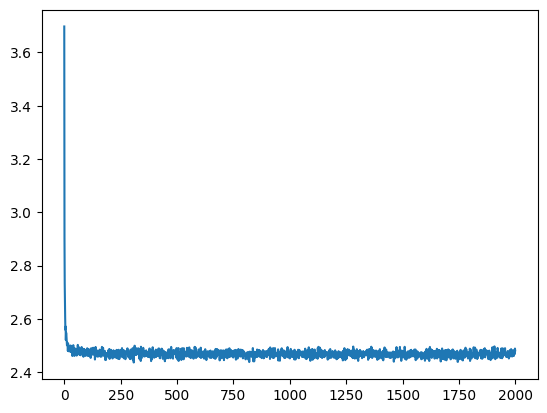

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

## Try different temperatures

Changing the distribution sharpness has an impact on character sampling:

more or less probable things are sampled

In [14]:

temps = [1, 0.8, 0.5, 0.3, 0.1]

for temp in temps:
  print(f"temperature = {temp} : {generate(model,'T', 200, temperature=temp)}")
  print("----------------------------------------------------------------")

temperature = 1 : TI wis, isoy y?
DY:
Cllouthewnthe-d,
AMI ir,
Wh owe a llld avive an doug; me cle fr ha-
AMowistoftouispry wense,
Wellinl Whang tillllos ayike, pon Wemarike bee MO:
found os.
HAUShamif marsedleso, hig o
----------------------------------------------------------------
temperature = 0.8 : Therowougrarilith a angar
PRO:
Pof gore o it lonof tonthed.

I whongouds be ardes t pokerapreithouroshe f t I ptore pan s s arars ashond cheator ace ayonthenour prend dionin dos lpeas areirs aspadre th
----------------------------------------------------------------
temperature = 0.5 : Thore s woroongoure th wit asherind, the ar ind d and theres, are me at mer ands t te ad thard t s s as thit bes the ter s pous pe at y s s s s s s ther t s,
And there ther'd, ary s tor l s s sered mad
----------------------------------------------------------------
temperature = 0.3 : There athe and t the the the thind mat t s s are thes I are the pre ares he thit and athere thend tous ther s the are the

### Improving this code:

(a) Tinker with parameters:

- Is it really necessary to have 100 dims character embeddings
- Chunk length can be gradually increased
- Try changing RNN cell type (GRUs - LSTMs)

(b) Add GPU support to go faster


In [12]:
n_epochs = 20000
print_every = 100
plot_every = 10
hidden_size = 300
n_layers = 5
lr = 0.005
batch_size = 16
chunk_len = 80

model = RNN(n_characters, hidden_size, n_characters, n_layers) #create model
model_optimizer = torch.optim.Adam(model.parameters(), lr=lr) #create Adam optimizer
criterion = nn.CrossEntropyLoss() #chose criterion

start = time.time()
all_losses = []
loss_avg = 0


def train(inp, target):
    """
    Train sequence for one chunk:
    """
    #reset gradients
    model_optimizer.zero_grad()

    # predict output
    output = model(inp)

    #compute loss
    loss =  criterion(output.view(batch_size*chunk_len,-1), target.view(-1))

    #compute gradients and backpropagate
    loss.backward()
    model_optimizer.step()

    return loss.data.item()



for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set(chunk_len,batch_size))
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(generate(model,'Wh', 100), '\n')



    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0


plt.figure()
plt.plot(all_losses)

 7s (100 0%) 2.4776]
Wherde er ur G ar f ad grarshein anth, athat f alis d bancingour s apour lt?
TELOKI lod wist cl this u 

 13s (200 1%) 2.5074]
Whesmersthindeat Thatandith s hes s yous fas t,
F ar ce icouspe te?

O:
O: thoknd t t torertoumacece s 

 20s (300 1%) 2.4963]
Whot!
As ave CIS:
'rdwre wis teave, ld ce
NGoos neardoth at any malerdy.
Ther avere mpt wif whitheard  

 27s (400 2%) 2.5552]
What iatitifo h t,
Th ave ot nd s fager er y t pe ary ndy; d ss d wane th chat thay d arte t y aththe  

 33s (500 2%) 2.5010]
Whe hyownd th therecunnowathiusedsthen acousty,
Fer r'ldesau my m mbul a shest,
O:
They d. an tr e fou 

 41s (600 3%) 2.5230]
Wh'd thit hen at toubuerer thy Thit, wartangh thathan t t bbicitall and, m mathim ded and, d t
INoun f 

 47s (700 3%) 2.4423]
Whe; shen he her dad ghouly fe, we d ar htordord;
re bukechathay hy th w nke thou s chamy ther wif fe  

 54s (800 4%) 2.5442]
Whag d arenenor, go ootooo ms t hit s blo spe borustorsinof o beches tspowhart y ctt daly 

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 80 but got size 79 for tensor number 6 in the list.